In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet18
model = torchvision.models.resnet18(pretrained=True)

# Modify the final layer for 10 classes (CIFAR10)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # New layer has `requires_grad=True` by default

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False  # This freezes ALL parameters, including `model.fc`!
# Now re-enable gradients ONLY for the final layer's parameters
for param in model.fc.parameters():
    param.requires_grad = True  # Correct way to unfreeze the new layer

# Data transformations and loaders
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Loss and optimizer (now includes unfrozen parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Works because `model.fc` has gradients


Files already downloaded and verified


In [5]:

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Now works because gradients are enabled
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.7933277268193886
Epoch 2, Loss: 0.6383591612618624
Epoch 3, Loss: 0.6178358517067599
Epoch 4, Loss: 0.6030194465731171
Epoch 5, Loss: 0.5980622470283539


In [6]:
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Files already downloaded and verified


In [7]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [8]:
# Calculate test accuracy
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 80.60%


In [9]:
# Load test dataset
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Evaluate model
model.eval()  # Ensure model is in evaluation mode
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Files already downloaded and verified
Final Test Accuracy: 80.60%


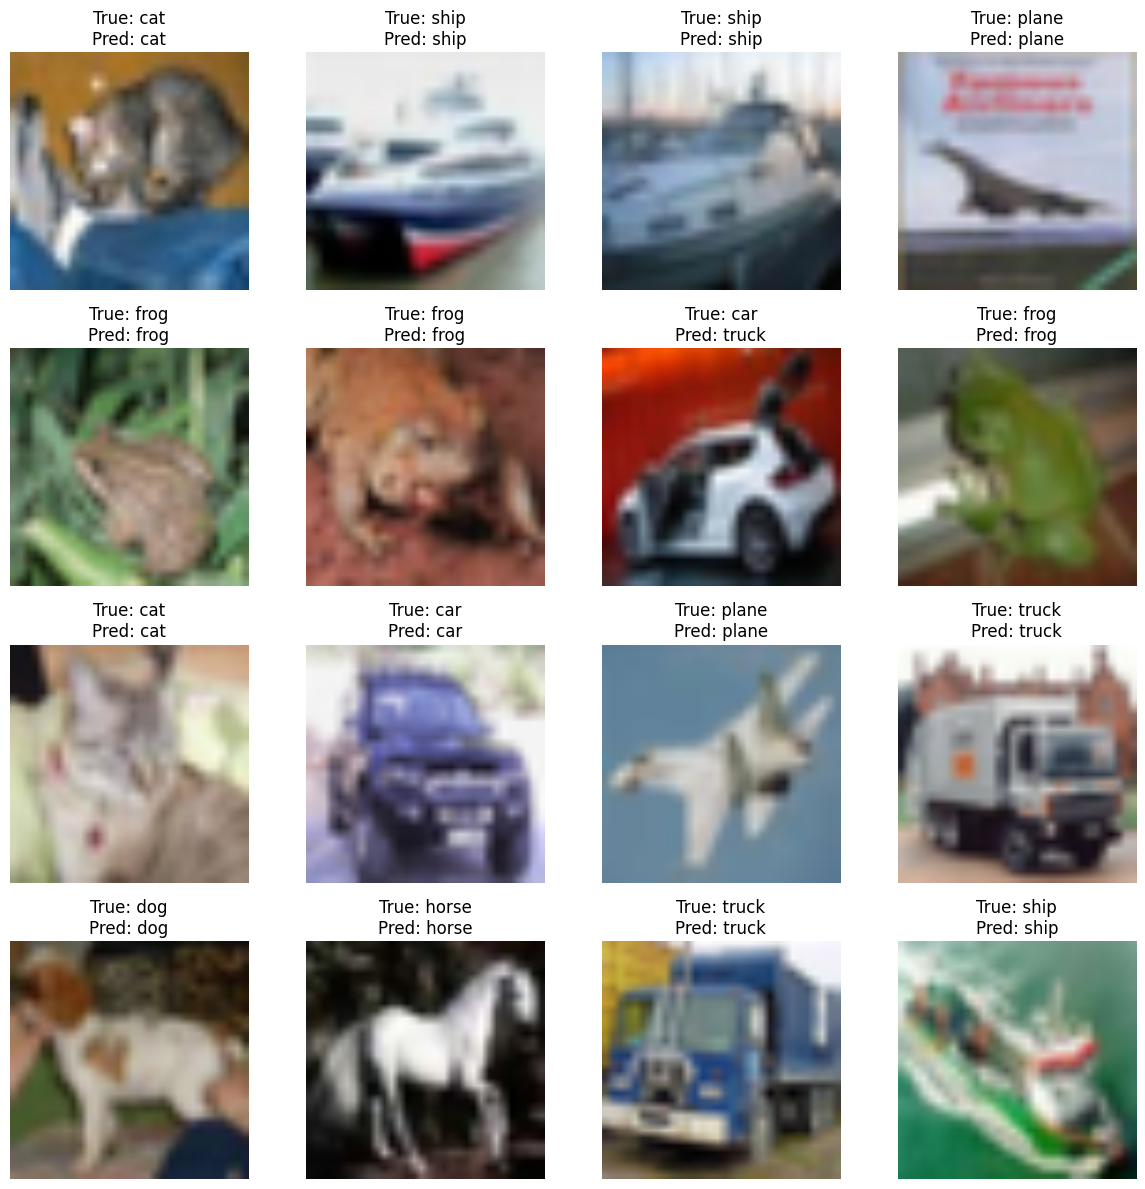

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels for CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Move images back to CPU for plotting
images = images.cpu().numpy()
labels = labels.cpu().numpy()
predicted = predicted.cpu().numpy()

# Plot results
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[idx], (1, 2, 0)) * 0.5 + 0.5)  # Undo normalization
    ax.set_title(f"True: {classes[labels[idx]]}\nPred: {classes[predicted[idx]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()